<a href="https://colab.research.google.com/github/bhargavi-12-10/Image-Classification-using-Transfer-learning/blob/main/Image_Classifier_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow numpy matplotlib requests opencv-python pytz

In [ ]:
# Cell 1: Check & Install Libraries
import subprocess

def install(package):
    subprocess.run(['pip', 'install', package])

# Base libraries (usually pre-installed)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Check & install if needed
try:
    import cv2
except ImportError:
    install('opencv-python')
    import cv2

# Not needed for this project, but included for completeness
try:
    import requests, pytz
except ImportError:
    install('requests pytz')

print("TensorFlow version:", tf.__version__)
print("All libraries installed successfully!")

TensorFlow version: 2.15.0
All libraries installed successfully!


In [ ]:
# Cell 2: Download and Extract Dataset
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip

# Our dataset is already structured, so we don't need to reorganize files
!ls -R cats_and_dogs_filtered

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


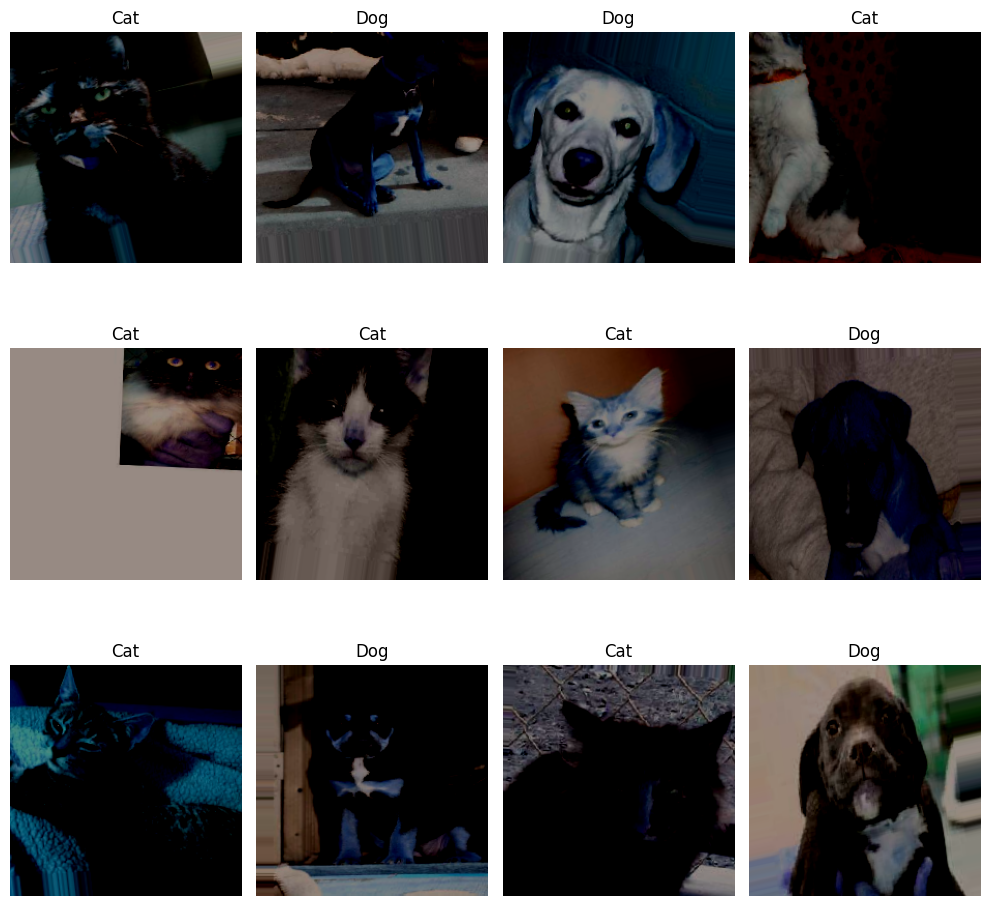

In [ ]:
# Cell 3: Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths and parameters
train_dir = 'cats_and_dogs_filtered/train'
val_dir = 'cats_and_dogs_filtered/validation'
img_size = (224, 224)  # VGG16 input size
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

# Load and augment data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Display some images
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i] / 255.0)
        plt.title('Dog' if label_batch[i] == 1 else 'Cat')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(train_generator)
show_batch(images, labels)

In [ ]:
# Cell 4: Model Architecture
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification (dog or cat)

model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Cell 5: Model Training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set up callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 5.1496 - accuracy: 0.9040 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 1958s 31s/step - loss: 5.1496 - accuracy: 0.9040 - val_loss: 1.6006 - val_accuracy: 0.9600
Epoch 2/10
63/63 [==============================] - 1942s 31s/step - loss: 1.7377 - accuracy: 0.9445 - val_loss: 1.4295 - val_accuracy: 0.9540
Epoch 3/10
63/63 [==============================] - 1950s 31s/step - loss: 1.0998 - accuracy: 0.9560 - val_loss: 0.4088 - val_accuracy: 0.9780
Epoch 4/10
63/63 [==============================] - 1945s 31s/step - loss: 0.7255 - accuracy: 0.9575 - val_loss: 0.1544 - val_accuracy: 0.9870
Epoch 5/10
63/63 [==============================] - 1950s 31s/step - loss: 0.3334 - accuracy: 0.9645 - val_loss: 0.3547 - val_accuracy: 0.9710
Epoch 6/10
63/63 [==============================] - 1951s 31s/step - loss: 0.3902 - accuracy: 0.9600 - val_loss: 0.3344 - val_accuracy: 0.9690
Epoch 7/10
63/63 [==============================] - 1938s 31s/step - loss: 0.2880 - accuracy: 0.9680 - val_loss: 0.2278 - val_accuracy: 0.9770


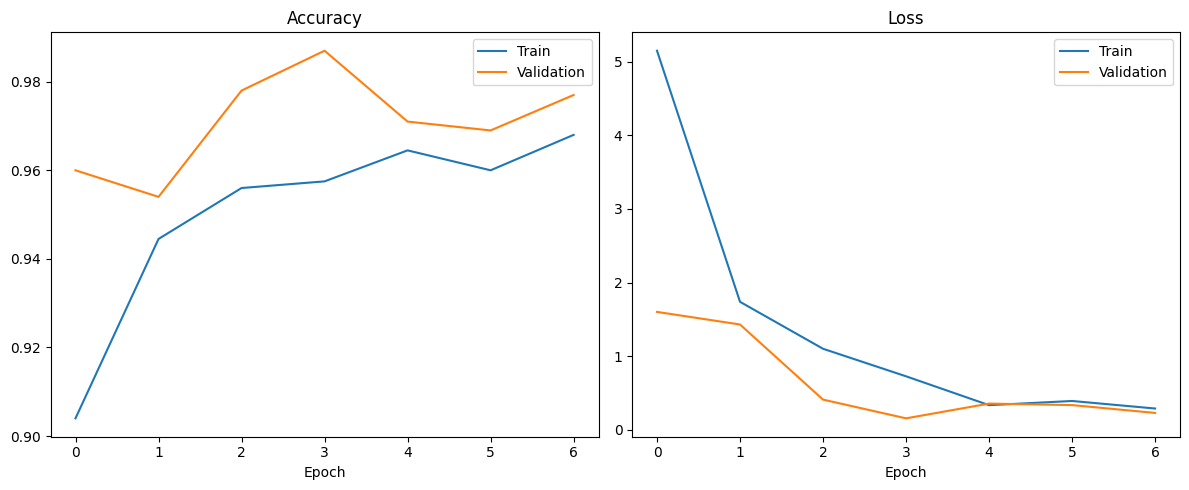

32/32 [==============================] - 631s 20s/step - loss: 0.2278 - accuracy: 0.9770
Test Accuracy: 0.9770


In [ ]:
# Cell 6: Evaluate Model
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on validation set
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# Cell 6: Evaluate Model

# Check if history object exists
if 'history' not in locals():
    print("Error: 'history' object not found. Make sure you've trained the model and saved the history.")
else:
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Evaluate on test set
if 'model' not in locals():
    print("Error: 'model' object not found. Make sure you've defined and compiled your model.")
elif 'test_generator' not in locals():
    print("Error: 'test_generator' not found. Make sure you've defined your test data generator.")
else:
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"Test Accuracy: {test_acc:.4f}")

Error: 'history' object not found. Make sure you've trained the model and saved the history.
Error: 'model' object not found. Make sure you've defined and compiled your model.


35363/35363 [==============================] - 0s 0us/step


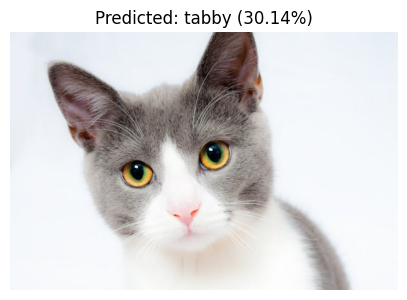

1/1 [==============================] - 0s 67ms/step


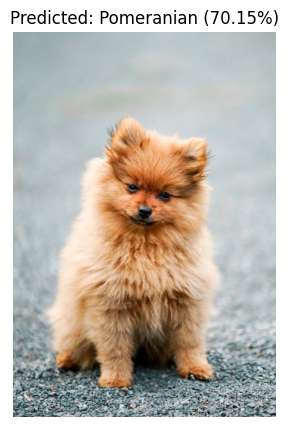

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the pre-trained MobileNet model
model = tf.keras.applications.MobileNet(weights='imagenet', include_top=True)

def predict_image_from_url(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    top_prediction = tf.keras.applications.mobilenet.decode_predictions(np.expand_dims(pred, axis=0), top=1)[0][0]
    class_name = top_prediction[1]
    confidence = top_prediction[2]

    return class_name, confidence

# Example images
dog_url = "https://images.pexels.com/photos/3687770/pexels-photo-3687770.jpeg?auto=compress&cs=tinysrgb&w=600"
cat_url = "https://images.pexels.com/photos/104827/cat-pet-animal-domestic-104827.jpeg?auto=compress&cs=tinysrgb&w=600"

for url in [cat_url, dog_url]:
    class_name, confidence = predict_image_from_url(url)

    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Predicted: {class_name} ({confidence:.2%})")
    plt.axis('off')
    plt.show()

In [ ]:
def index(request):
    if(request.method=="POST"):
        data=request.POST
        a=float(data.get('HAEMATOCRIT'))
        b=float(data.get('HAEMOGLOBIN'))
        c=float(data.get('ERYTHROCYT'))
        d=float(data.get('THROMBOCYTE'))
        e=float(data.get('LEUCOCYTE'))
        f=float(data.get('MCH'))
        g=float(data.get('MCHC'))
        h=float(data.get('AGE'))
        i=float(data.get('MCV'))
        j=(data.get('SEX'))
        if('submit' in request.POST):
            #K Nearest Neighbors
            import pandas as pd
            path="C:\\Users\\hp\\Desktop\\Projectt\\GUI\\Data\\data.csv"
            data=pd.read_csv(path)
            print(data.info())
            print(data)

            # Map 'SEX' column to numerical values
            print(data['SEX'].unique())
            print(data['SEX'].nunique())
            data['SEX']=data['SEX'].map({'M':0,'F':1})
            print(data)

            # Map 'SOURCE' column to numerical values
            print(data['SOURCE'].unique())
            print(data['SOURCE'].nunique())
            data['SOURCE']=data['SOURCE'].map({'in':0,'out':1})
            print(data)

            inputs = data.drop(['SOURCE'], axis='columns')
            output = data.drop(['HAEMATOCRIT','HAEMOGLOBINS','ERYTHROCYTE','THROMBOCYTE','LEUCOCYTE','MCH','MCHC','AGE','MCV','SEX'], axis='columns')

            print(inputs)
            print(output)
            import sklearn
            from sklearn.model_selection import train_test_split
            x_train,x_test,y_train,y_test=train_test_split(inputs,output,test_size=0.8)

            from sklearn.neighbors import KNeighborsClassifier
            model=KNeighborsClassifier(n_neighbors=13)

            model.fit(x_train,y_train)               #training
            y_pred=model.predict(x_test)
            print(y_pred)
            print(y_test)

            from sklearn.metrics import confusion_matrix
            cm=confusion_matrix(y_test,y_pred)
            print(cm)
            result=model.predict([[1.1,2.2,3.1,3.2,6.7,6,4.5,3.9,7.9,8]]) # Make sure the input to predict is numerical
            print(result)
        return render(request,'index.html',context={'result':result})
    return render(request,"index.html")

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the pre-trained MobileNet model
model = tf.keras.applications.MobileNet(weights='imagenet', include_top=True)

def predict_image_from_url(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    top_prediction = tf.keras.applications.mobilenet.decode_predictions(np.expand_dims(pred, axis=0), top=1)[0][0]
    class_name = top_prediction[1]
    confidence = top_prediction[2]

    return class_name, confidence

def classify_and_display_image(url):
    class_name, confidence = predict_image_from_url(url)

    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Predicted: {class_name} ({confidence:.2%})")
    plt.axis('off')
    plt.show()

# Example usage
if __name__ == "__main__":
    while True:
        url = input("Enter an image URL (or 'quit' to exit): ")
        if url.lower() == 'quit':
            break
        classify_and_display_image(url)

Enter an image URL (or 'quit' to exit): quit


Enter image URLs (one per line). Type 'done' when finished:
https://images.pexels.com/photos/1390361/pexels-photo-1390361.jpeg?auto=compress&cs=tinysrgb&w=600
https://images.pexels.com/photos/38008/pexels-photo-38008.jpeg?auto=compress&cs=tinysrgb&w=600
https://images.pexels.com/photos/3114143/pexels-photo-3114143.jpeg?auto=compress&cs=tinysrgb&w=600
https://images.pexels.com/photos/1390784/pexels-photo-1390784.jpeg?auto=compress&cs=tinysrgb&w=600
done
35363/35363 [==============================] - 0s 0us/step


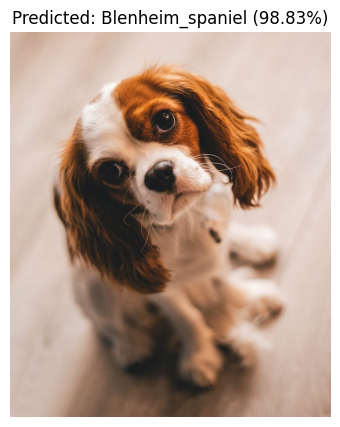

1/1 [==============================] - 0s 64ms/step


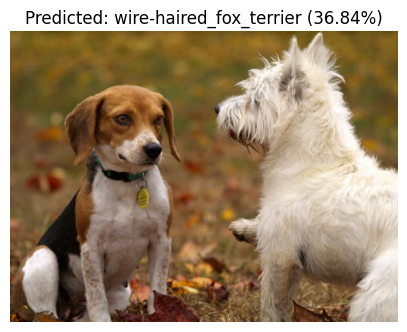

1/1 [==============================] - 0s 56ms/step


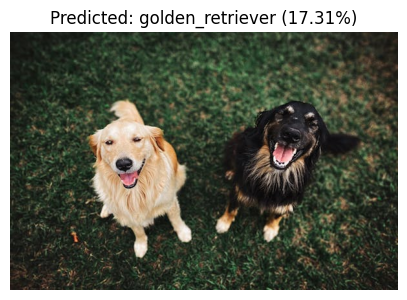

1/1 [==============================] - 0s 53ms/step


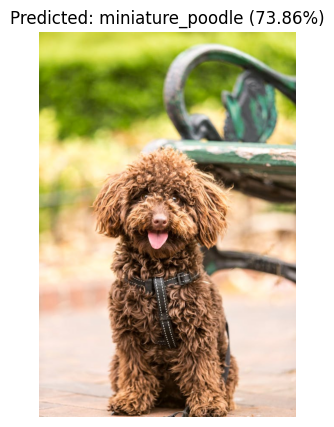


Classification Results:
URL: https://images.pexels.com/photos/1390361/pexels-photo-1390361.jpeg?auto=compress&cs=tinysrgb&w=600
Predicted: Blenheim_spaniel (Confidence: 98.83%)

URL: https://images.pexels.com/photos/38008/pexels-photo-38008.jpeg?auto=compress&cs=tinysrgb&w=600
Predicted: wire-haired_fox_terrier (Confidence: 36.84%)

URL: https://images.pexels.com/photos/3114143/pexels-photo-3114143.jpeg?auto=compress&cs=tinysrgb&w=600
Predicted: golden_retriever (Confidence: 17.31%)

URL: https://images.pexels.com/photos/1390784/pexels-photo-1390784.jpeg?auto=compress&cs=tinysrgb&w=600
Predicted: miniature_poodle (Confidence: 73.86%)

Do you want to classify more images? (yes/no): no


In [ ]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the pre-trained MobileNet model
model = tf.keras.applications.MobileNet(weights='imagenet', include_top=True)

def predict_image_from_url(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    top_prediction = tf.keras.applications.mobilenet.decode_predictions(np.expand_dims(pred, axis=0), top=1)[0][0]
    class_name = top_prediction[1]
    confidence = top_prediction[2]

    return class_name, confidence

def classify_and_display_image(url):
    try:
        class_name, confidence = predict_image_from_url(url)

        response = requests.get(url)
        img = Image.open(BytesIO(response.content))

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Predicted: {class_name} ({confidence:.2%})")
        plt.axis('off')
        plt.show()

        return f"URL: {url}\nPredicted: {class_name} (Confidence: {confidence:.2%})\n"
    except Exception as e:
        return f"Error processing {url}: {str(e)}\n"

def get_user_input():
    print("Enter image URLs (one per line). Type 'done' when finished:")
    urls = []
    while True:
        url = input()
        if url.lower() == 'done':
            break
        urls.append(url)
    return urls

def main():
    while True:
        urls = get_user_input()
        if not urls:
            print("No URLs entered. Exiting.")
            break

        results = []
        for url in urls:
            result = classify_and_display_image(url)
            results.append(result)

        print("\nClassification Results:")
        for result in results:
            print(result)

        continue_choice = input("Do you want to classify more images? (yes/no): ")
        if continue_choice.lower() != 'yes':
            break

if __name__ == "__main__":
    main()

Found 3 image(s). Processing...
1/1 [==============================] - 1s 588ms/step


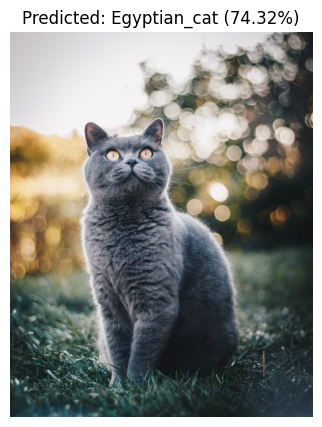

File: pexels-photo-1521306.jpeg
Predicted: Egyptian_cat (Confidence: 74.32%)

1/1 [==============================] - 0s 97ms/step


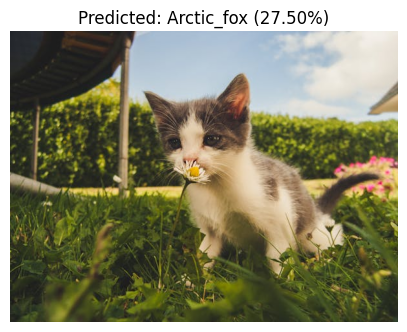

File: pexels-photo-1472999.jpeg
Predicted: Arctic_fox (Confidence: 27.50%)

1/1 [==============================] - 0s 125ms/step


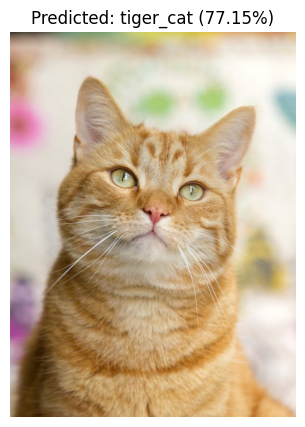

File: pexels-photo-736532.jpeg
Predicted: tiger_cat (Confidence: 77.15%)



In [ ]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the pre-trained MobileNet model
model = tf.keras.applications.MobileNet(weights='imagenet', include_top=True)

def predict_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    top_prediction = tf.keras.applications.mobilenet.decode_predictions(np.expand_dims(pred, axis=0), top=1)[0][0]
    class_name = top_prediction[1]
    confidence = top_prediction[2]

    return class_name, confidence

def classify_and_display_image(img_path):
    try:
        class_name, confidence = predict_image(img_path)

        img = Image.open(img_path)

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Predicted: {class_name} ({confidence:.2%})")
        plt.axis('off')
        plt.show()

        return f"File: {os.path.basename(img_path)}\nPredicted: {class_name} (Confidence: {confidence:.2%})\n"
    except Exception as e:
        return f"Error processing {os.path.basename(img_path)}: {str(e)}\n"

def get_image_paths(directory):
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(directory, ext)))
    return image_files

# Main execution
directory = '/content'  # or '/content/your_folder_name' if you uploaded to a specific folder
image_paths = get_image_paths(directory)

if not image_paths:
    print(f"No image files found in {directory}")
else:
    print(f"Found {len(image_paths)} image(s). Processing...")

    for img_path in image_paths:
        result = classify_and_display_image(img_path)
        print(result)

Found 6 image(s). Processing...


1/1 [==============================] - 1s 701ms/step


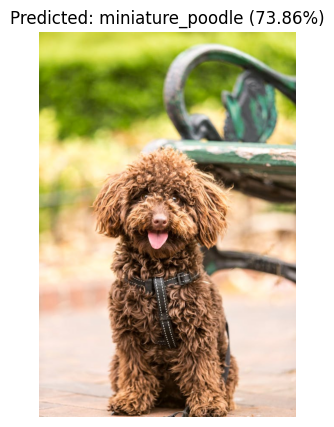

File: dog.jpeg
Predicted: miniature_poodle (Confidence: 73.86%)

1/1 [==============================] - 0s 103ms/step


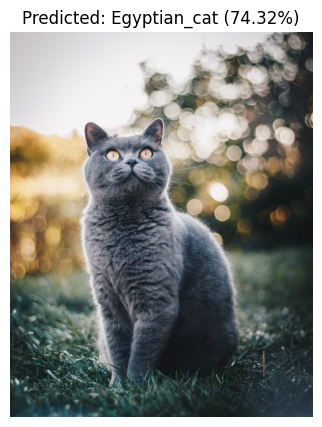

File: pexels-photo-1521306.jpeg
Predicted: Egyptian_cat (Confidence: 74.32%)

1/1 [==============================] - 0s 96ms/step


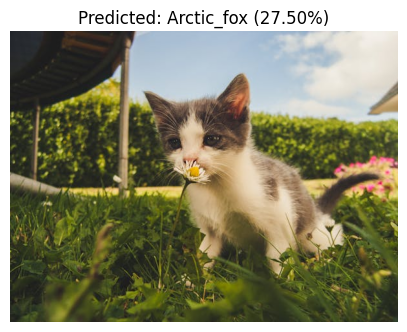

File: pexels-photo-1472999.jpeg
Predicted: Arctic_fox (Confidence: 27.50%)

1/1 [==============================] - 0s 94ms/step


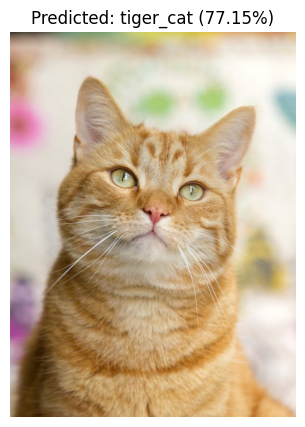

File: pexels-photo-736532.jpeg
Predicted: tiger_cat (Confidence: 77.15%)

1/1 [==============================] - 0s 102ms/step


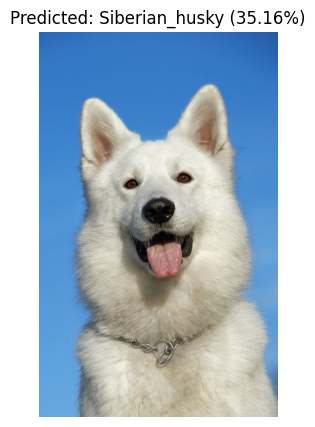

File: swiss-shepherd-dog-dog-pet-portrait-46505.jpeg
Predicted: Siberian_husky (Confidence: 35.16%)

1/1 [==============================] - 0s 93ms/step


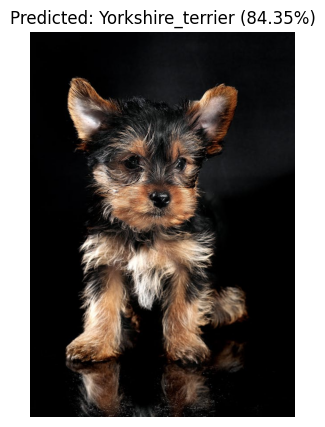

File: pexels-photo-1420405.jpeg
Predicted: Yorkshire_terrier (Confidence: 84.35%)



In [ ]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the pre-trained MobileNet model
model = tf.keras.applications.MobileNet(weights='imagenet', include_top=True)

def predict_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    top_prediction = tf.keras.applications.mobilenet.decode_predictions(np.expand_dims(pred, axis=0), top=1)[0][0]
    class_name = top_prediction[1]
    confidence = top_prediction[2]

    return class_name, confidence

def classify_and_display_image(img_path):
    try:
        class_name, confidence = predict_image(img_path)

        img = Image.open(img_path)

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Predicted: {class_name} ({confidence:.2%})")
        plt.axis('off')
        plt.show()

        return f"File: {os.path.basename(img_path)}\nPredicted: {class_name} (Confidence: {confidence:.2%})\n"
    except Exception as e:
        return f"Error processing {os.path.basename(img_path)}: {str(e)}\n"

def get_image_paths(directory):
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(directory, ext)))
    return image_files

# Main execution
directory = '/content'  # or '/content/your_folder_name' if you uploaded to a specific folder
image_paths = get_image_paths(directory)

if not image_paths:
    print(f"No image files found in {directory}")
else:
    print(f"Found {len(image_paths)} image(s). Processing...")

    for img_path in image_paths:
        result = classify_and_display_image(img_path)
        print(result)

In [ ]:
pip install pillow numpy matplotlib tensorflow

In [ ]:
import PIL; print(PIL.__version__)

In [ ]:
print(Image.open.__doc__)



    Opens and identifies the given image file.

    This is a lazy operation; this function identifies the file, but
    the file remains open and the actual image data is not read from
    the file until you try to process the data (or call the
    :py:meth:`~PIL.Image.Image.load` method).  See
    :py:func:`~PIL.Image.new`. See :ref:`file-handling`.

    :param fp: A filename (string), pathlib.Path object or a file object.
       The file object must implement ``file.read``,
       ``file.seek``, and ``file.tell`` methods,
       and be opened in binary mode.
    :param mode: The mode.  If given, this argument must be "r".
    :param formats: A list or tuple of formats to attempt to load the file in.
       This can be used to restrict the set of formats checked.
       Pass ``None`` to try all supported formats. You can print the set of
       available formats by running ``python3 -m PIL`` or using
       the :py:func:`PIL.features.pilinfo` function.
    :returns: An :py:class:`~P